In [3]:
# %matplotlib widget
from matplotlib import pyplot as plt
from IPython.display import Audio
import scipy
import numpy as np
from pathlib import Path
from IPython.display import HTML
from IPython.display import display, clear_output
import ipywidgets as widgets
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import mpl_interactions.ipyplot as iplt
from mpl_interactions.widgets import scatter_selector_index
import sounddevice as sd
import random
import time
import scipy
# HTML('''<style>.jupyter-matplotlib {background-color: #000;}.widget-label{color: #fff;}.jupyter-matplotlib-header{color: #000!important;}.jupyter-button {background-color: #333;color: #fff;}</style>''')
plt.style.use('default')

In [2]:
def load_samples(path, label):
	samples = []
	for sample_path in path.glob('*.wav'):
		sample_rate, sample = scipy.io.wavfile.read(sample_path)
		# sample = sample.mean(axis=1)
		# trim silence
		start_i = np.argmax(sample > 0.005)
		samples.append((sample[start_i:], label))
	return samples

low_dataset =  load_samples(Path('dataset/cut_filtered/kck0'), 0) + load_samples(Path('dataset/cut_filtered/kck1'), 0) + load_samples(Path('dataset/cut_filtered/kck2'), 0) + load_samples(Path('dataset/cut_filtered/kck3'), 0) 
high_dataset =  load_samples(Path('dataset/cut_filtered/snr0'), 1) + load_samples(Path('dataset/cut_filtered/snr1'), 1) + load_samples(Path('dataset/cut_filtered/snr2'), 1) + load_samples(Path('dataset/cut_filtered/snr3'), 1)
print(f"Low dataset size: {len(low_dataset)}")
print(f"High dataset size: {len(high_dataset)}")

random.shuffle(low_dataset)
random.shuffle(high_dataset)

split = len(low_dataset)//4
test_dataset_raw = low_dataset[:split] + high_dataset[:split]
train_dataset_raw = low_dataset[split:] + high_dataset[split:]
random.shuffle(train_dataset_raw)
random.shuffle(test_dataset_raw)

print(f"Train dataset size: {len(train_dataset_raw)}")
print(f"Test dataset size: {len(test_dataset_raw)}")

Low dataset size: 264
High dataset size: 277
Train dataset size: 409
Test dataset size: 132


In [16]:
def preprocess_sample(sample, window_size):
	sample = sample[:window_size]
	statistics_features = [
		sample.mean(),
		sample.std(),
		sample.max(),
		sample.min(),
		np.percentile(sample, 25),
		np.percentile(sample, 75),
		np.percentile(sample, 90),
		np.percentile(sample, 10),
		scipy.stats.kurtosis(sample),
		scipy.stats.skew(sample),
		scipy.stats.iqr(sample),
	]
	return np.array(statistics_features)

def preprocess_dataset(dataset, window_size):
		samples_preprocessed = []
		for sample, label in dataset:
			sample_fft = preprocess_sample(sample, window_size)
			samples_preprocessed.append((sample_fft, label))
		return samples_preprocessed

Window size: 64 samples, 1.45 ms
Window size: 128 samples, 2.90 ms
Window size: 256 samples, 5.80 ms
Window size: 512 samples, 11.61 ms


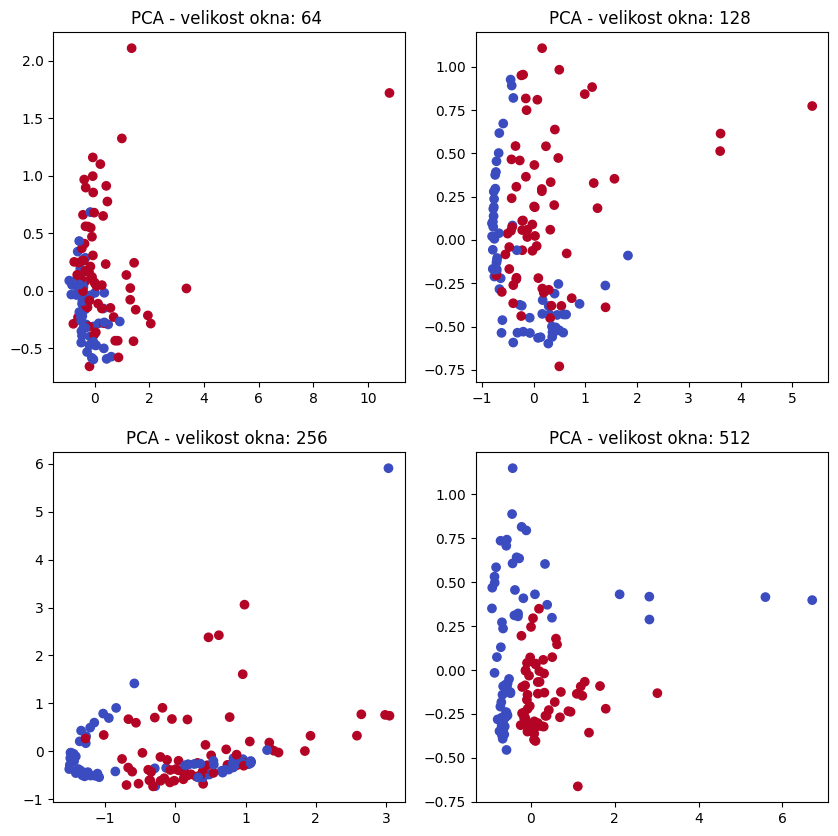

In [5]:
plt.figure(figsize=(10, 10))
for i, window_size in enumerate([64, 128, 256, 512]):
	print(f"Window size: {window_size} samples, {window_size/44100*1000:.2f} ms")

	# Preprocess the dataset - apply FFT and trim to window size
	train_dataset = preprocess_dataset(train_dataset_raw, window_size)
	test_dataset = preprocess_dataset(test_dataset_raw, window_size)

	train_samples = np.array([sample for sample, label in train_dataset])
	train_labels = np.array([label for sample, label in train_dataset])

	test_samples = np.array([sample for sample, label in test_dataset])
	test_labels = np.array([label for sample, label in test_dataset])

	pca = PCA(n_components=2)
	pca.fit(train_samples)

	samples_pca = pca.transform(test_samples)
	
	plt.subplot(2, 2, i+1)
	plt.title(f'PCA - velikost okna: {window_size} ')
	plt.scatter(samples_pca[:, 0], samples_pca[:, 1], c=test_labels, cmap='coolwarm')

plt.savefig('img/pca_stats.png', dpi=300)
	

In [22]:
def test_model(model, preprocess_dataset, label, title):
	window_sizes = [64, 128, 256, 512]
	test_accuracies = []
	train_accuracies = []
	training_times = []
	inference_times = []
	for i, window_size in enumerate(window_sizes):
		train_dataset = preprocess_dataset(train_dataset_raw, window_size)
		test_dataset = preprocess_dataset(test_dataset_raw, window_size)

		train_samples = np.array([sample for sample, label in train_dataset])
		train_labels = np.array([label for sample, label in train_dataset])

		test_samples = np.array([sample for sample, label in test_dataset])
		test_labels = np.array([label for sample, label in test_dataset])

		start = time.time()
		model.fit(train_samples, train_labels)
		end = time.time()
		training_times.append((end-start)*1000)

		train_accuracy = accuracy_score(model.predict(train_samples), train_labels)
		start = time.time()
		labels = model.predict(test_samples)
		end = time.time()
		inference_times.append((end-start)*1000)
		test_accuracy = accuracy_score(labels, test_labels)
		test_accuracies.append(test_accuracy)
		train_accuracies.append(train_accuracy)

	plt.figure(figsize=(5, 5))
	plt.bar([1, 3, 5, 7], train_accuracies, label='Točnost na učni množici')
	plt.bar([x-0.2 for x in [2, 4, 6, 8]], test_accuracies, label='Točnost na testni množici')
	plt.xticks([x+0.4 for x in [1, 3, 5, 7]], ['64', '128', '256', '512'])
	plt.xlabel('Velikost okna')
	plt.ylabel('Klasifikacijska točnost')
	plt.title(title)
	plt.legend(loc="lower right")
	plt.tight_layout()
	plt.savefig(f'img/stats/{label}.png', dpi=300)

	print("\\begin{tabular}{r | c c c c c}")
	print(f"\\multicolumn{{5}}{{c}}{{{title}}}\\\\")
	print("\\tiny{Velikost okna} & " + ' & '.join([f'\\small{{{window_size}}}' for window_size in window_sizes]) + "\\\\ \\hline")
	print("\\tiny{Točnost} & " + ' & '.join([f'\\small{{{test_accuracy:.2f}}}' for test_accuracy in test_accuracies]) + "\\\\")
	print("\\tiny{Učna točnost} & " + ' & '.join([f'\\small{{{train_accuracy:.2f}}}' for train_accuracy in train_accuracies])  + "\\\\")
	print("\\tiny{Čas učenja} & " + ' & '.join([f'\\small{{{training_time:.2f}}}' for training_time in training_times]) + "\\\\")
	print("\\tiny{Čas napovedi} & " + ' & '.join([f'\\small{{{inference_time:.2f}}}' for inference_time in inference_times]) + "\\\\")
	print("\\end{tabular}")
	# print("\\textbf{Velikost okna} & \\textbf{Točnost na učni množici} & \\textbf{Točnost na testni množici} & \\textbf{Čas učenja} & \\textbf{Čas napovedi} \\\\ \\hline")
	# for window_size, train_accuracy, test_accuracy, training_time, inference_time in zip(window_sizes, train_accuracies, test_accuracies, training_times, inference_times):
	# 	print(f"{window_size} & {train_accuracy:.2f} & {test_accuracy:.2f} & {training_time:.2f} & {inference_time:.2f} \\\\")



\begin{tabular}{r | c c c c c}
\multicolumn{5}{c}{SVC z normalizacijo}\\
\tiny{Velikost okna} & \small{64} & \small{128} & \small{256} & \small{512}\\ \hline
\tiny{Točnost} & \small{0.87} & \small{0.94} & \small{0.95} & \small{0.96}\\
\tiny{Učna točnost} & \small{0.82} & \small{0.91} & \small{0.96} & \small{0.98}\\
\tiny{Čas učenja} & \small{3.86} & \small{2.02} & \small{1.50} & \small{2.00}\\
\tiny{Čas napovedi} & \small{1.00} & \small{0.00} & \small{0.00} & \small{0.00}\\
\end{tabular}


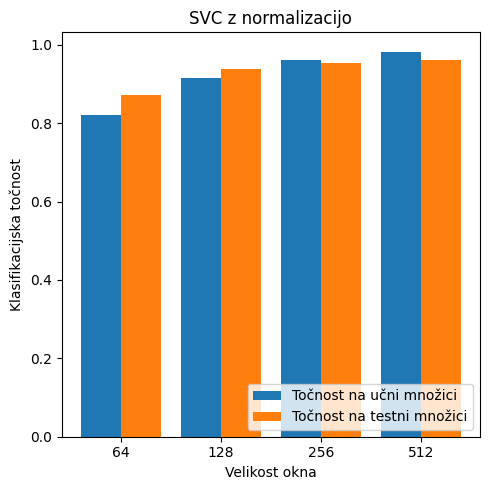

In [23]:
svc =  SVC(kernel='linear', C=0.7)
clf = make_pipeline(StandardScaler(), svc)
test_model(clf, preprocess_dataset, 'svc_fft_scaled', 'SVC z normalizacijo')

\begin{tabular}{r | c c c c c}
\multicolumn{5}{c}{k najbližjih sosedov}\\
\tiny{Velikost okna} & \small{64} & \small{128} & \small{256} & \small{512}\\ \hline
\tiny{Točnost} & \small{0.73} & \small{0.80} & \small{0.86} & \small{0.98}\\
\tiny{Učna točnost} & \small{0.85} & \small{0.87} & \small{0.94} & \small{0.99}\\
\tiny{Čas učenja} & \small{1.00} & \small{1.00} & \small{1.00} & \small{1.00}\\
\tiny{Čas napovedi} & \small{1.70} & \small{2.00} & \small{2.01} & \small{2.00}\\
\end{tabular}


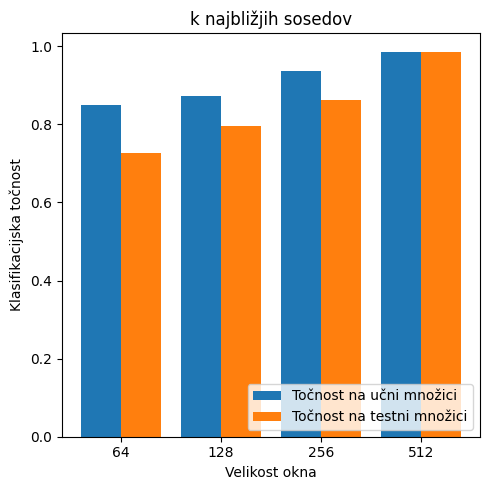

In [24]:
test_model(KNeighborsClassifier(n_neighbors=2), preprocess_dataset, 'knn_fft', 'k najbližjih sosedov')

\begin{tabular}{r | c c c c c}
\multicolumn{5}{c}{Logistična regresija}\\
\tiny{Velikost okna} & \small{64} & \small{128} & \small{256} & \small{512}\\ \hline
\tiny{Točnost} & \small{0.80} & \small{0.72} & \small{0.63} & \small{0.88}\\
\tiny{Učna točnost} & \small{0.76} & \small{0.75} & \small{0.67} & \small{0.86}\\
\tiny{Čas učenja} & \small{2.00} & \small{2.27} & \small{2.01} & \small{2.00}\\
\tiny{Čas napovedi} & \small{0.00} & \small{0.00} & \small{1.00} & \small{0.00}\\
\end{tabular}


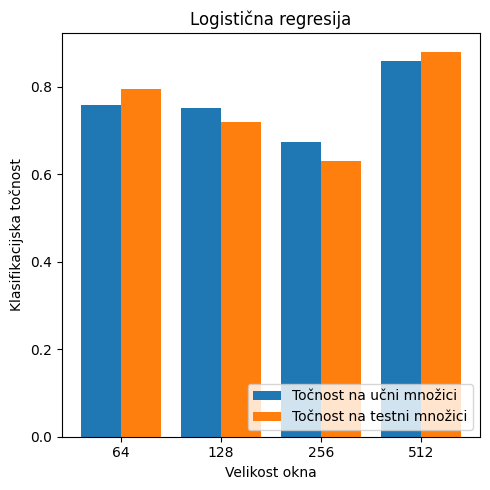

In [25]:
test_model(linear_model.LogisticRegression(), preprocess_dataset, 'logreg_fft', 'Logistična regresija')

\begin{tabular}{r | c c c c c}
\multicolumn{5}{c}{Naključni gozd}\\
\tiny{Velikost okna} & \small{64} & \small{128} & \small{256} & \small{512}\\ \hline
\tiny{Točnost} & \small{0.85} & \small{0.92} & \small{0.97} & \small{0.98}\\
\tiny{Učna točnost} & \small{1.00} & \small{1.00} & \small{1.00} & \small{1.00}\\
\tiny{Čas učenja} & \small{99.86} & \small{92.01} & \small{82.54} & \small{88.96}\\
\tiny{Čas napovedi} & \small{2.00} & \small{2.00} & \small{2.51} & \small{2.00}\\
\end{tabular}


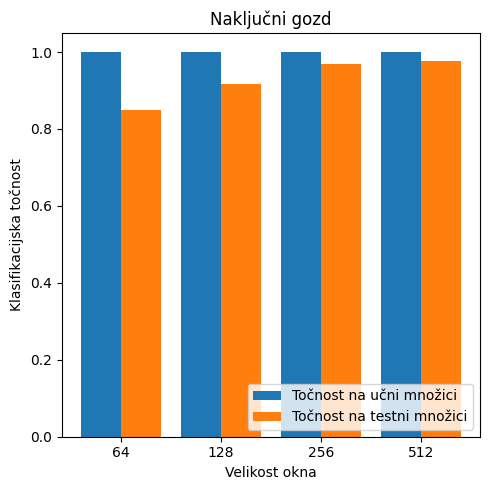

In [26]:
test_model(RandomForestClassifier(max_depth=20), preprocess_dataset, 'gozd_fft', 'Naključni gozd')

\begin{tabular}{r | c c c c c}
\multicolumn{5}{c}{Gosta nevronska mreža (32, 4)}\\
\tiny{Velikost okna} & \small{64} & \small{128} & \small{256} & \small{512}\\ \hline
\tiny{Točnost} & \small{0.79} & \small{0.86} & \small{0.95} & \small{0.99}\\
\tiny{Učna točnost} & \small{0.77} & \small{0.84} & \small{0.97} & \small{1.00}\\
\tiny{Čas učenja} & \small{428.72} & \small{246.72} & \small{281.31} & \small{326.81}\\
\tiny{Čas napovedi} & \small{0.00} & \small{0.00} & \small{0.00} & \small{0.00}\\
\end{tabular}


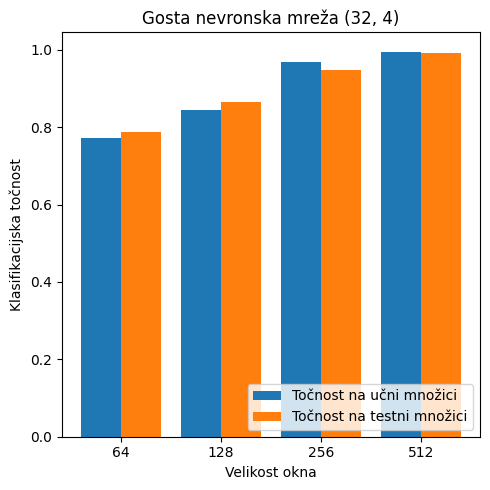

In [34]:
test_model(MLPClassifier(hidden_layer_sizes=(32,4), max_iter=1000), preprocess_dataset, 'nn_32_4_fft', 'Gosta nevronska mreža (32, 4)')